<a href="https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_09_2_face_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# T81-558: Applications of Deep Neural Networks

**Module 9: Facial Recognition**

- Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
- For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).


# Module 9 Material

- Part 9.1: Detecting Faces in an Image [[Video]](https://www.youtube.com/watch?v=Hpp3D3P2iWQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_1_faces.ipynb)
- **Part 9.2: Detecting Facial Features** [[Video]](https://www.youtube.com/watch?v=AblTbq0T2wE&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_2_face_features.ipynb)
- Part 9.3: Reality Augmentation [[Video]](https://www.youtube.com/watch?v=jfZDiRxx5Bc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_3_reality_augmentation.ipynb)
- Part 9.4: Application: Emotion Detection [[Video]](https://www.youtube.com/watch?v=F0H6vojQhE8&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_4_emotion.ipynb)
- Part 9.5: Application: Blink Efficiency [[Video]](https://www.youtube.com/watch?v=96LPEStHCUA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_5_blink.ipynb)


# Google CoLab Instructions

The following code checks that Google CoLab is and sets up the correct hardware settings for PyTorch.


In [ ]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch

device = (
    "mps"
    if getattr(torch, "has_mps", False)
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")


if device!='cuda':
  print("*******WARNING, this notebook requires a CUDA GPU****")
  print("This notebook will not work correctly!")

Note: using Google CoLab
Using device: cuda


# Part 9.2: Detecting Facial Features

Facial landmark detection is a sophisticated aspect of computer vision that focuses on identifying and locating specific points of interest on a face. These points, or landmarks, typically correspond to anatomically meaningful positions such as the corners of the eyes, the tip of the nose, the endpoints of the mouth, and the contour of the jawline, among others. The aim is to capture the geometric structure and features of a face in a detailed manner. Once detected, these landmarks serve as pivotal reference points for a plethora of applications ranging from facial alignment and emotion recognition to augmented reality filters and advanced facial animation. The precision and reliability of facial landmark detection algorithms are paramount, given their profound implications in fields like security, healthcare, entertainment, and user experience enhancement. Detecting these landmarks allows for a deeper understanding and interpretation of facial expressions, movements, and nuances, bridging the gap between mere face detection and intricate facial analysis.

The detection of these landmarks opens the door to a myriad of applications:

* **Facial Alignment**: Landmarks can be used to align faces, ensuring that the eyes, nose, and mouth are consistently positioned. This is crucial for facial recognition systems as it can help in normalizing face images for comparison.

* **Emotion Recognition**: By analyzing the position and movement of facial landmarks, especially around the mouth and eyebrows, it's possible to deduce a person's emotional state.

* **Face Morphing and Augmentation**: Landmarks serve as reference points for morphing one face into another or for augmenting features in applications like Snapchat or Instagram filters.

* **Face Animation**: In animation and gaming, facial landmarks can be used to map and replicate human facial expressions onto animated characters.

* **Gaze Tracking**: By observing the position and orientation of eye landmarks, it's possible to determine where a person might be looking.

* **Facial Feature Extraction**: For cosmetic or medical applications, precise landmarking can assist in feature extraction, measuring facial symmetry, or planning surgeries.

* **Speech Therapy and Lip Reading**: Landmarks around the mouth can assist in understanding lip movements, aiding in speech therapy or in developing lip-reading algorithms.

Currently one of the most accurate facial landmark detection algorithms is [Shape Preserving Facial Landmarks with Graph Attention Networks (SPIGA)](https://github.com/andresprados/SPIGA). The authors of this paper also provided working code at a [GitHub](https://github.com/andresprados/SPIGA) repository. In this section we will make use of facenet-pytorch to detect faces and SPIGA to find 97 different facial landmarks on individual faces.

We begin by installing SPIGA and facenet.

In [ ]:
# Setup SPIGA and facenet
!pip install facenet-pytorch
!git clone https://github.com/andresprados/SPIGA.git
%cd SPIGA/
!pip install -e .

Cloning into 'SPIGA'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 331 (delta 2), reused 2 (delta 0), pack-reused 324
Receiving objects: 100% (331/331), 128.87 MiB | 33.27 MiB/s, done.
Resolving deltas: 100% (125/125), done.
Updating files: 100% (120/120), done.
/content/SPIGA/SPIGA
Obtaining file:///content/SPIGA/SPIGA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for spiga (pyproject.toml) ... done
  Created wheel for spiga: filename=spiga-0.0.6-0.editable-py3-none-any.whl size=7963 sha256=2793c971c33af7b0e33123092ee88cffb3c0ead8204b84f5ca7ed029fa0d29bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-jomkinrm/wheels/0b/7c/f5/20cc26a6085edf6626ed2e1e898af2880e18df23d3a00f6408
Successfully built spiga
  A

Previously, we worked with images in the PIL format in Python. OpenCV is another standard image processing library in Python, often explicitly used by machine learning applications. In this chapter, we will need to use both PIL and OpenCV. The MTCNN model we use to detect faces accepts PIL images, whereas the SPIGA model uses OpenCV-style images to detect facial landmarks. This requirement means that our code will need to support both formats. The following code loads an image both as OpenCV and PIL.

In [ ]:
import requests
import cv2
import numpy as np
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN

url = "https://data.heatonresearch.com/images/jeff/about-jeff-heaton-2020.jpg"

# Download the image using requests
response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
response.raise_for_status()

# Convert the downloaded bytes to a numpy array
image = np.asarray(bytearray(response.content), dtype="uint8")

# Decode the numpy array to an OpenCV image
img = cv2.imdecode(image, cv2.IMREAD_COLOR)

# Convert the OpenCV image (NumPy array) to a PIL Image
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

Next we detect the bounding boxes for all images. The first bounding box has the highest probability of being a face.

In [ ]:
mtcnn = MTCNN(keep_all=True, device=device)

# Detect faces
boxes, _ = mtcnn.detect(image_pil)

The following code uses PIL to draw rectangles around all detected faces. Though this image only contains one face, multiple false positives are detected. If you can assume that there will be only one face in an image, it is safe to simply use the first rectangle as the face, which is the approach we will take in this section.

[575.5524291992188 218.17938232421875 1177.603515625 1042.155029296875]
Found a face at the bounding box, Left: 575.5524291992188, Top: 218.17938232421875, Right: 1177.603515625, Bottom: 1042.155029296875
[-45.25502395629883 177.9632110595703 65.65013885498047 316.43157958984375]
Found a face at the bounding box, Left: -45.25502395629883, Top: 177.9632110595703, Right: 65.65013885498047, Bottom: 316.43157958984375
[1165.85205078125 806.6883544921875 1198.0787353515625 849.19873046875]
Found a face at the bounding box, Left: 1165.85205078125, Top: 806.6883544921875, Right: 1198.0787353515625, Bottom: 849.19873046875
[1079.2708740234375 1143.361328125 1104.694580078125 1175.5863037109375]
Found a face at the bounding box, Left: 1079.2708740234375, Top: 1143.361328125, Right: 1104.694580078125, Bottom: 1175.5863037109375


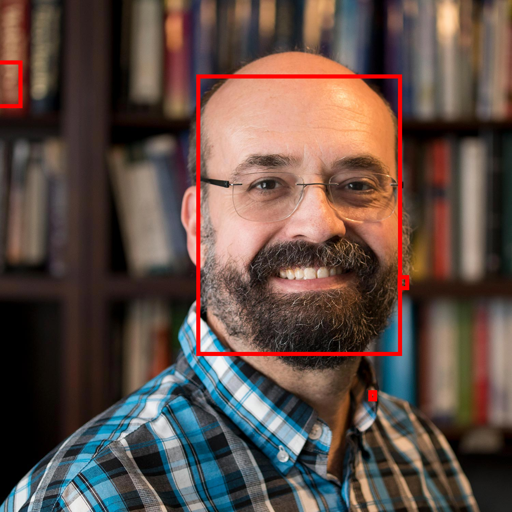

In [ ]:
# Prepare to draw on the image
draw = ImageDraw.Draw(image_pil)

# Draw bounding boxes
for box in boxes:
    draw.rectangle(box.tolist(), outline="red", width=12)
    print(box)
    print(f"Found a face at the bounding box, Left: {box[0]}, Top: {box[1]}, Right: {box[2]}, Bottom: {box[3]}")

# Scale and show image results
aspect_ratio = image_pil.height / image_pil.width
new_height = int(aspect_ratio * 512)

# Resize the image
display(image_pil.resize((512, new_height)))

Next we will call SPIGA and provide the bounding box for the detected face. SPIGA will return a list of 97 detected facial features.

In [ ]:
from spiga.inference.config import ModelConfig
from spiga.inference.framework import SPIGAFramework

x0 = int(boxes[0][0])
y0 = int(boxes[0][1])
x1 = int(boxes[0][2])
y1 = int(boxes[0][3])
bbox = [x0,y0,y1,y1]

# Load image
image = cv2.imread(url)

print(bbox)
#bbox = [165, 100, 338, 338]
#bbox = [50,0,100,100]

# Process image
dataset = 'wflw'
processor = SPIGAFramework(ModelConfig(dataset))
features = processor.inference(img, [bbox])


[575, 218, 1042, 1042]


Downloading: "https://drive.google.com/uc?export=download&confirm=yes&id=1h0qA5ysKorpeDNRXe9oYkVcVe8UYyzP7" to /content/SPIGA/spiga/models/weights/spiga_wflw.pt
100%|██████████| 243M/243M [00:03<00:00, 66.7MB/s]


SPIGA model loaded!


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


The provided code is designed to visualize specific features on an image, most related to SPIGA's facial landmark recognition. First, the code imports the necessary modules, including  **Plotter** from SPIGA, which is specificially designed to display SPIGA's output. The image is displayed by **cv2_imshow**, which is specifically made for displaying images in Google Colab. After preparing the required variables, a deep copy of the image (img) is stored in the variable canvas. It then extracts landmark and head pose information from the features dictionary. With the use of the **Plotter** object, these landmarks and the head pose are drawn onto the canvas. In addition to this, a green-colored bounding box is also plotted on the canvas around coordinates (x0, y0) and (x1, y1). Finally, the modified image is resized to a width of 512 pixels while maintaining its aspect ratio, and then it's displayed within the Google Colab environment using cv2_imshow.

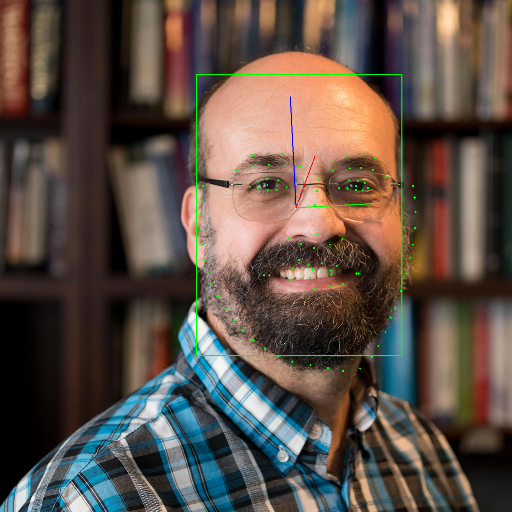

In [ ]:
import copy
from spiga.demo.visualize.plotter import Plotter
from google.colab.patches import cv2_imshow

# Prepare variables


canvas = copy.deepcopy(img)
landmarks = np.array(features['landmarks'][0])
headpose = np.array(features['headpose'][0])

# Plot features
plotter = Plotter()
canvas = plotter.landmarks.draw_landmarks(canvas, landmarks)
canvas = plotter.hpose.draw_headpose(canvas, [x0, y0, x1, y1], headpose[:3], headpose[3:], euler=True)

# Bounding box
color = (0, 255, 0)  # Green color
thickness = 2
cv2.rectangle(canvas, (x0,y0), (x1,y1), color, thickness)


# Show image results
(h, w) = canvas.shape[:2]
canvas = cv2.resize(canvas, (512, int(h*512/w)))
cv2_imshow(canvas)

The facial landmarks are numbered, as seen below. You can make use of these array indexes to find the facial data you need.

![Facial Landmarks](https://data.heatonresearch.com/images/wustl/class/face-landmarks.jpg)

* Facial Perimeter: points 0 to 32 (green)
* Right Eyebrow: points 33 to 41 (blue)
* Left Eyebrow: points 42 to 50 (blue)
* Nose: points 51 to 59 (purple)
* Right Eye: points 60 to 67 (red)
* Left Eye: points 68 to 75 (red)
* Lips: points 76 to 87 (cyan)
* Mouth: points 88 to 95 (yellow)
* Pupals: points 96 (right) and 97 (left, red)
